In [2]:

########################################################################################
# Sai Vivek Kammari
# A1807677
# Masters of Data Science
# University Of Adelaide
########################################################################################

!pip install pmdarima
!pip install emot
import pandas as pd
import re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from pandas import Series
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
import numpy as np 
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import sklearn.metrics as metrics
import math
import xgboost
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas import concat

nltk.download('punkt')


     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 47.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import files
uploaded = files.upload()
with open('/content/creed3.txt') as f:
  data = f.read()


Saving creed3.txt to creed3.txt


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Covid_data.csv to Covid_data.csv


In [5]:
covid = pd.read_csv('Covid_data.csv')

In [6]:
data =data.lower()
# converting emojis to text
data = data.replace('total=',"total ")
data = data.replace('total:',"total ")
def emojis_text(text_data):
  for emot in UNICODE_EMOJI:
    text_data = text_data.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(":", "").split()))
  return text_data

# function to call convert the data into a dataframe with messages and dates seperated

def converttoDataFrame(data, pattern):
    #pattern ='\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s\wm' 
    messages = re.split(pattern,data)[1:]
    dates = re.findall(pattern, data)
    df = pd.DataFrame({'user_message': messages, 'date': dates})
    return df
  
pattern ='\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s\wm' 
df =converttoDataFrame(data, pattern)

In [7]:
# seperate the authors and the messages in the dataframe
def extractUser(dataframe):
    users = [] # empty users list
    messages = [] # empty messages list
    for message in dataframe['user_message']:
        str1 = re.split('([\w\W]+?):\s', message)
        if str1[1:]:  # user name
            users.append(str1[1])
            messages.append(" ".join(str1[2:]))
        else:
            users.append('notification')
            messages.append(str1[0])
    return users, messages
users, messages = extractUser(df)
df['user']=users
df['message']= messages
df.drop(columns =["user_message"], inplace =True)

In [8]:
df.head()

,date,user,message
0,"8/10/17, 1:25 am",notification,- messages and calls are end-to-end encrypted...
1,"8/10/17, 1:25 am",notification,"- adda created group ""creed collection""\n"
2,"8/10/17, 1:25 am",notification,- adda added +91 83413 83062\n
3,"8/10/17, 1:25 am",notification,- adda changed this group's icon\n
4,"8/10/17, 1:25 am",- adda,vijay ping everyday collection here\n


In [9]:
df['message'] =df['message'].apply(emojis_text) # converting emojis to text

# function to spit the date and time
def spli_date_time(df):
    date1 = []
    time = []
    for l in df['date']:
        entry = re.split(', ', l)
        date1.append(entry[0])
        time.append(entry[1])
    return date1, time

dates, time = spli_date_time(df)

df['dates']=dates
df['time']= time

In [10]:
# identified a list of special symbols in the text messages. This list might have to extend with new data

df['message']= df['message'].str.replace('\u202d'," ")
df['message']= df['message'].str.replace('\u202c'," ")
df['message']= df['message'].str.replace('\u2019'," ")
df['message']= df['message'].str.replace('\u2018'," ")

df['message']= df['message'].str.replace('\u200d'," ")

df['message']= df['message'].str.replace('\xb0'," ")

df['message']= df['message'].str.replace('\ufe0f'," ")

df['message']= df['message'].str.replace('\u2013'," ")
df['message']= df['message'].str.replace('\u2068'," ")
df['message']= df['message'].str.replace('\u2069'," ")
df['message']= df['message'].str.replace('\uff1a'," ")
df['message']= df['message'].str.replace('\u200e'," ")

df['message']= df['message'].str.replace('\xa0'," ")

df['message']= df['message'].str.replace('\xe1'," ")
df['message']= df['message'].str.replace('\uff1b'," ")

df['message']= df['message'].str.replace('\u2022'," ")
df['message']= df['message'].str.replace('\u20b9'," ")
df['message']= df['message'].str.replace('\xd7'," ")
df['message']= df['message'].str.replace('\u201c'," ")
df['message']= df['message'].str.replace('\u201d'," ")
df['message'][2683]= " "
df['message'] = df['message'].str.replace('₹', 'ruppes')




In [11]:
df['message2']=df['message'].astype('|S')

for i in range(len(df)):
    df.iloc[i,-1]=df.iloc[i,-1].decode('utf-8')
df = df[['dates', 'time','user','message', 'message2']]
df['message3']=df['message2'].str.decode("utf-8")

# splitiing each line into a seperate row of message 3

str1 = df['message3'].str.split('\n').apply(Series, 1).stack()
str1.index = str1.index.droplevel(-1) 
str1.name = 'message3' # needs a name to join
del df['message3']
df2= df.join(str1)

df2

,dates,time,user,message,message2,message3
0,8/10/17,1:25 am,notification,- messages and calls are end-to-end encrypted...,b' - messages and calls are end-to-end encrypt...,- messages and calls are end-to-end encrypted...
0,8/10/17,1:25 am,notification,- messages and calls are end-to-end encrypted...,b' - messages and calls are end-to-end encrypt...,
1,8/10/17,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'","- adda created group ""creed collection"""
1,8/10/17,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'",
2,8/10/17,1:25 am,notification,- adda added +91 83413 83062\n,b' - adda added +91 83413 83062\n',- adda added +91 83413 83062
...,...,...,...,...,...,...
9411,7/28/21,11:25 am,- vijay creed gym,27th july sale\n\n3m @6490 (creed qr code)\n,b'27th july sale\n\n3m @6490 (creed qr code)\n',
9412,7/28/21,2:32 pm,- adda,paid 150 for printer tech from axis (bro4u)\n,b'paid 150 for printer tech from axis (bro4u)\n',paid 150 for printer tech from axis (bro4u)
9412,7/28/21,2:32 pm,- adda,paid 150 for printer tech from axis (bro4u)\n,b'paid 150 for printer tech from axis (bro4u)\n',
9413,7/28/21,2:32 pm,- adda,paid 1000 from axis for instagram post promoti...,b'paid 1000 from axis for instagram post promo...,paid 1000 from axis for instagram post promotion


In [12]:
test = df2.copy()
test['dates'] = pd.DatetimeIndex(test['dates'])

test["year"] = test["dates"].apply(lambda x: x.year) # adding the year column

test["month"] = test["dates"].apply(lambda x: x.strftime("%b")) # adding the months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
test['month'] = pd.Categorical(test['month'], months)
test

,dates,time,user,message,message2,message3,year,month
0,2017-08-10,1:25 am,notification,- messages and calls are end-to-end encrypted...,b' - messages and calls are end-to-end encrypt...,- messages and calls are end-to-end encrypted...,2017,Aug
0,2017-08-10,1:25 am,notification,- messages and calls are end-to-end encrypted...,b' - messages and calls are end-to-end encrypt...,,2017,Aug
1,2017-08-10,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'","- adda created group ""creed collection""",2017,Aug
1,2017-08-10,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'",,2017,Aug
2,2017-08-10,1:25 am,notification,- adda added +91 83413 83062\n,b' - adda added +91 83413 83062\n',- adda added +91 83413 83062,2017,Aug
...,...,...,...,...,...,...,...,...
9411,2021-07-28,11:25 am,- vijay creed gym,27th july sale\n\n3m @6490 (creed qr code)\n,b'27th july sale\n\n3m @6490 (creed qr code)\n',,2021,Jul
9412,2021-07-28,2:32 pm,- adda,paid 150 for printer tech from axis (bro4u)\n,b'paid 150 for printer tech from axis (bro4u)\n',paid 150 for printer tech from axis (bro4u),2021,Jul
9412,2021-07-28,2:32 pm,- adda,paid 150 for printer tech from axis (bro4u)\n,b'paid 150 for printer tech from axis (bro4u)\n',,2021,Jul
9413,2021-07-28,2:32 pm,- adda,paid 1000 from axis for instagram post promoti...,b'paid 1000 from axis for instagram post promo...,paid 1000 from axis for instagram post promotion,2021,Jul


In [13]:
# creating seperate dataframes for each year
for i in range(2017,2022):

  if i ==2017:
    test_2017 = test[test['year']==2017]

  elif i ==2018:
    test_2018 = test[test['year']==2018]
  elif i ==2019:
    test_2019 = test[test['year']==2019]
  elif i ==2020:
    test_2020 = test[test['year']==2020]
  else :
    test_2021 = test[test['year']==2021]

# 2017

In [14]:
# selecting 2017 data and filtering for the records corresponding to sales information
df4 =test_2017
df4=df4[df4['message'].str.contains("sale|collection|total")]

# function to extract the number from text message
def find_number(text):
  text = text.replace(',', '')

  num = re.findall(r'[0-9,]+',text)
  return " ".join(num)
df4['number']=df4['message3'].apply(lambda x: find_number(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [15]:
df4['tokenized_words'] = df4['message3'].apply(nltk.word_tokenize)

sale_words =['transfer','gpay','phonepe','card','online', 'transfered','cash','axis','hdfc','account',
             'paytm','qr','total', 'xfer', 'cc', 'emi', 'cheque','a/c.transfer','total=', 'tez']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
def mode_payment(l1):
  l2 =[]
  sale_Words = ['transfer','gpay','phonepe','card','online', 'transfered','cash','axis','hdfc','account',
             'paytm','qr','total']
  for j in range(len(l1)):
        if l1[j] in sale_words:
            l2.append(l1[j])
  return l2

  df4['paymenmodet_mode']=df4['tokenized_words'].apply(lambda x: mode_payment(x))

In [17]:
df4['mode']= 0
#df4

for i in range(len(df4)):
    l1 =  df4.iloc[i,-2]
    for j in l1:
        if j in sale_words:
            df4.iloc[i,-1]= j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [18]:
df4.head()

,dates,time,user,message,message2,message3,year,month,number,tokenized_words,mode
1,2017-08-10,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'","- adda created group ""creed collection""",2017,Aug,,"[-, adda, created, group, ``, creed, collectio...",0
1,2017-08-10,1:25 am,notification,"- adda created group ""creed collection""\n","b' - adda created group ""creed collection""\n'",,2017,Aug,,[],0
4,2017-08-10,1:25 am,- adda,vijay ping everyday collection here\n,b'vijay ping everyday collection here\n',vijay ping everyday collection here,2017,Aug,,"[vijay, ping, everyday, collection, here]",0
4,2017-08-10,1:25 am,- adda,vijay ping everyday collection here\n,b'vijay ping everyday collection here\n',,2017,Aug,,[],0
5,2017-08-10,1:25 am,- adda,only collection\n,b'only collection\n',only collection,2017,Aug,,"[only, collection]",0


In [19]:
# filtering for only messages related to sale

df4=df4[df4['message'].str.contains("sale|collection|total")]

def split_number(df):
  num2=[]

  for number in df['number']:
    entry = re.split(' ' , number)
    num2.append(entry)

  return  num2 

df5 = df4.copy()
num1 = split_number(df5)
df5['number_list'] = num1



In [20]:
def getting_sale(list1):
  xx = []
  if len(list1) ==2:
    xx = list1[1]
  elif len(list1) ==1:
    xx = list1[0]
  return xx

In [21]:
df5['sales']=df5['number_list'].apply(lambda x: getting_sale(x))

In [22]:
df5 = df5[df5['number']!='']
df5 = df5[df5['number']!='']
df5 = df5[df5['mode']!= 0]
df5 = df5[df5['mode'].str.contains("total")]
df6 = df5[['dates','mode', 'sales',]]

df6['sales']=df6['sales'].astype(int)
df6.info()

df6['sales']=df6['sales'].astype(int)

sale_2017 = df6.groupby(['dates', 'mode'],  as_index=False)['sales'].sum()

sale_2017

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 12 to 2177
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   132 non-null    datetime64[ns]
 1   mode    132 non-null    object        
 2   sales   132 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.1+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,dates,mode,sales
0,2017-08-12,total,30000
1,2017-08-13,total,30000
2,2017-08-14,total,21500
3,2017-08-15,total,6000
4,2017-08-16,total,21000
...,...,...,...
113,2017-12-27,total,39536
114,2017-12-28,total,39598
115,2017-12-29,total,2107382
116,2017-12-30,total,37460


Text(0.5, 1.0, '2017 Daily_sales')

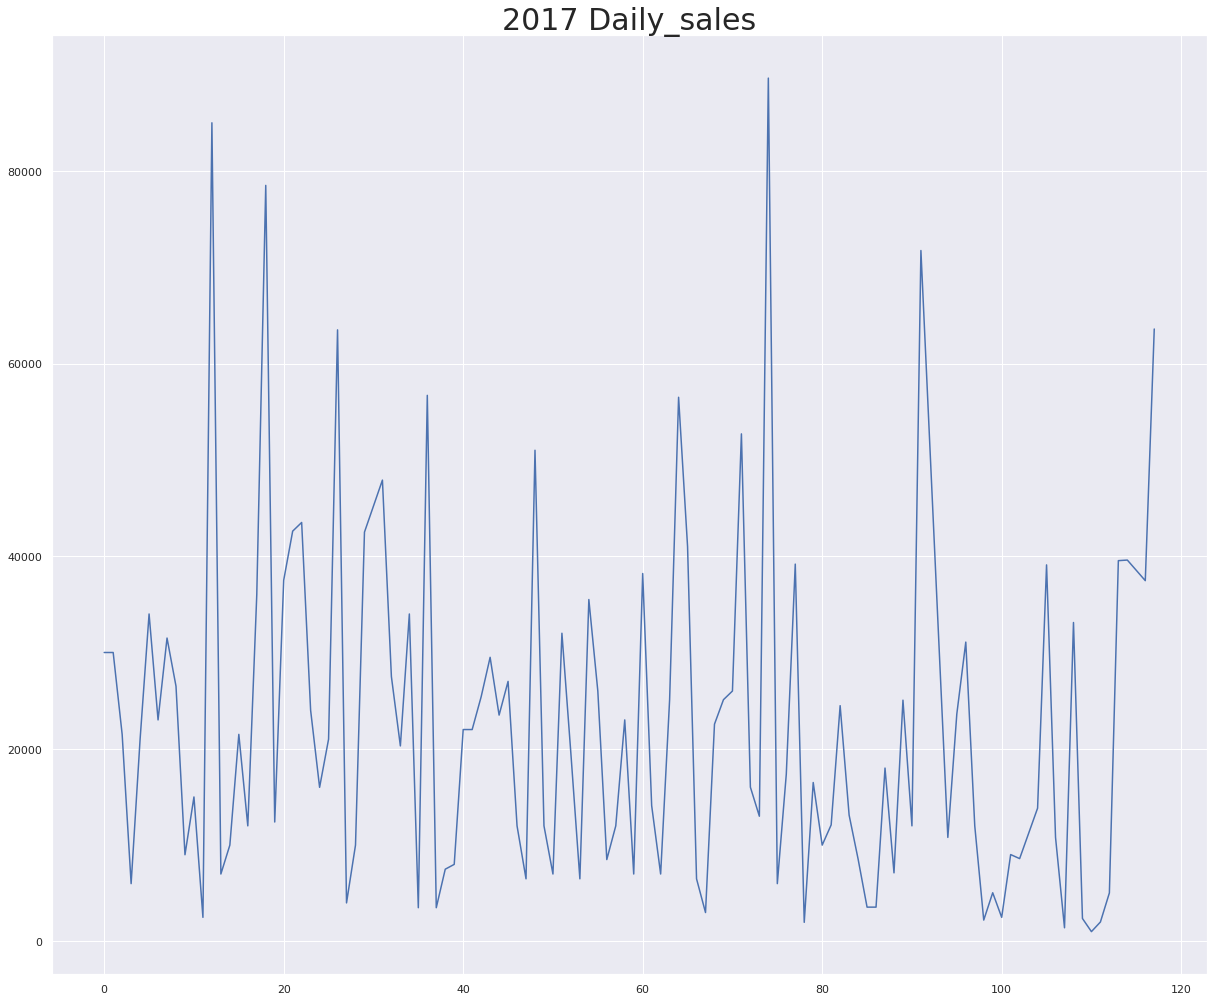

In [23]:
sns.set(rc={'figure.figsize':(20.7,17.2714)})
sale_2017 = sale_2017[sale_2017['sales']<100000]
sale_2017['sales'].dropna().plot()

plt.title( '2017 Daily_sales', fontsize = 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '2017 Weekly_sales')

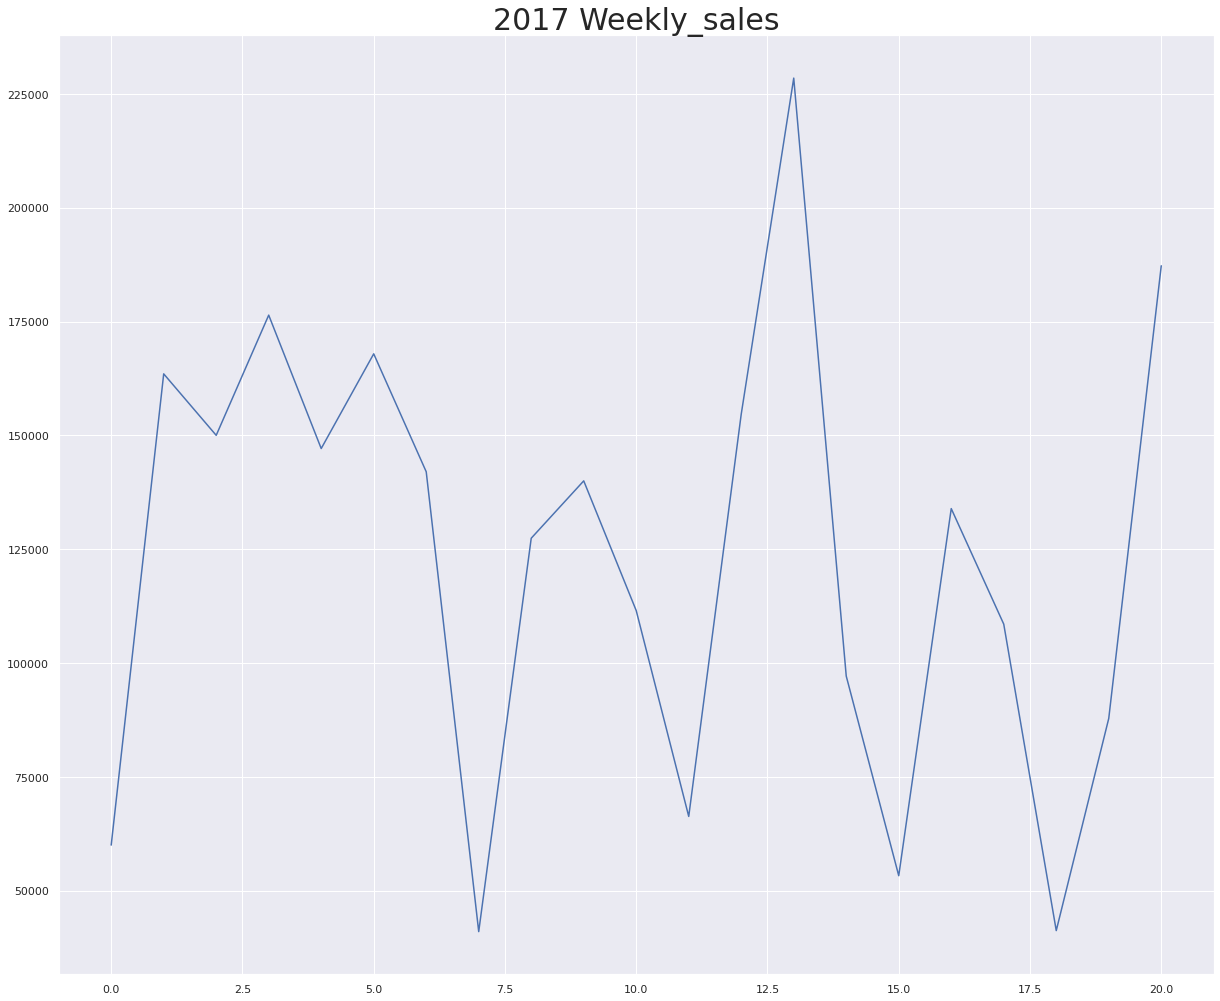

In [24]:
sale_2017['week_number'] = sale_2017['dates'].dt.week
sale_2017 = sale_2017.groupby([ 'week_number'],  as_index=False)['sales'].sum()
#sale_2017 = sale_2017.groupby([ 'week_number'],  as_index=False)['sales'].sum()
sale_2017['sales'].dropna().plot()

plt.title( '2017 Weekly_sales', fontsize = 30)

# 2018

In [25]:
df4 =test_2018
df4=df4[df4['message'].str.contains("sale|collection|total")]
df4['number']=df4['message3'].apply(lambda x: find_number(x))
df4['tokenized_words'] = df4['message3'].apply(nltk.word_tokenize)

df4['mode']= 0
#df4

for i in range(len(df4)):
    l1 =  df4.iloc[i,-2]
    for j in l1:
        if j in sale_words:
            df4.iloc[i,-1]= j


df5 = df4.copy()
num1 = split_number(df5)
df5['number_list'] = num1

df5['sales']=df5['number_list'].apply(lambda x: getting_sale(x))

df5 = df5[df5['number']!='']
df5 = df5[df5['mode']!= 0]
df5 = df5[df5['mode'].str.contains("total")]
df6 = df5[['dates','mode', 'sales',]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

# 2019


In [26]:
data =data.lower()
data = data.replace('total=',"total ")
data = data.replace('total:',"total ")

df4 =test_2019
#df4['message']= df['message'].str.replace('total=',"total ")
df4=df4[df4['message'].str.contains("sale|collection|total")]
df4['number']=df4['message3'].apply(lambda x: find_number(x))
df4['tokenized_words'] = df4['message3'].apply(nltk.word_tokenize)



df4['mode']= 0
#df4

for i in range(len(df4)):
    l1 =  df4.iloc[i,-2]
    for j in l1:
        if j in sale_words:
            df4.iloc[i,-1]= j

df5 = df4.copy()
num1 = split_number(df5)
df5['number_list'] = num1


def getting_sale(list1):
  xx = []
  if len(list1) >1:
    xx = 0
  elif len(list1) ==1:
    xx = list1[0]
  return xx
df5['sales']=df5['number_list'].apply(lambda x: getting_sale(x))

df5 = df5[df5['number']!='']
df5 = df5[df5['mode']!= 0]
df5 = df5[df5['mode'].str.contains("total")]
df6 = df5[['dates','mode', 'sales',]]
df6['sales'].astype(str).astype(int)
df6['sales']=df6['sales'].astype(int)

sale_2019 = df6.groupby(['dates', 'mode'],  as_index=False)['sales'].sum()
sale_2019 = df6[df6['sales']<100000]
sale_2019['week_number'] = sale_2019['dates'].dt.week

sale_2019.iloc[-1,-1] = 53
sale_2019 = sale_2019.groupby([ 'week_number'],  as_index=False)['sales'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Text(0.5, 1.0, '2019 Weekly_sales')

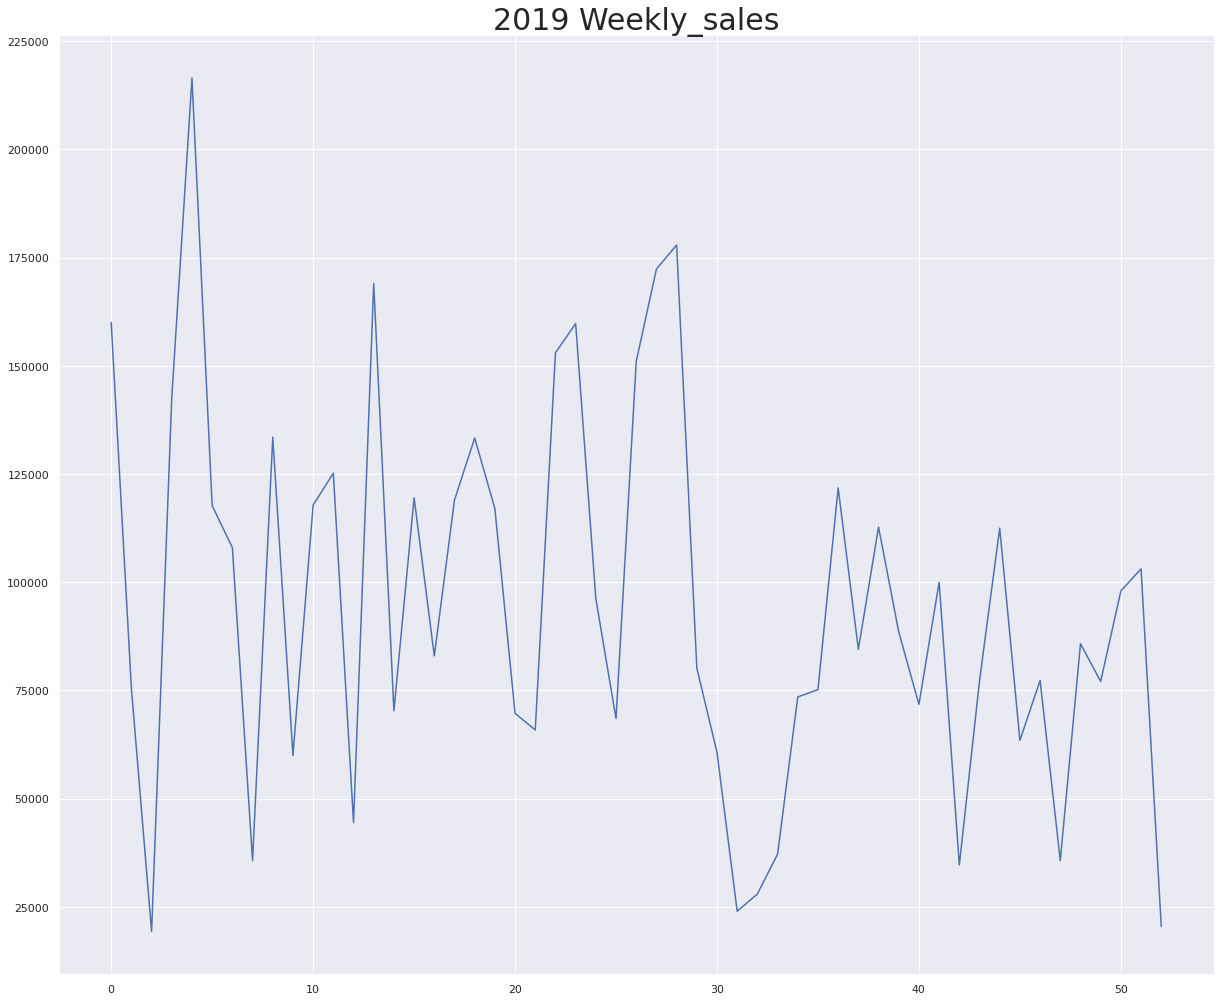

In [27]:
sale_2019['sales'].plot()

plt.title( '2019 Weekly_sales', fontsize = 30)

# 2020

In [28]:
df4 =test_2020
#df4['message']= df['message'].str.replace('total=',"total ")
df4=df4[df4['message'].str.contains("sale|collection|total")]
df4['number']=df4['message3'].apply(lambda x: find_number(x))
df4['tokenized_words'] = df4['message3'].apply(nltk.word_tokenize)

df4['mode']= 0
#df4

for i in range(len(df4)):
    l1 =  df4.iloc[i,-2]
    for j in l1:
        if j in sale_words:
            df4.iloc[i,-1]= j

df5 = df4.copy()
num1 = split_number(df5)
df5['number_list'] = num1
df6 = df5.copy()
df6 = df6[df6['number']!=0] 
df6 = df6[df6['number']!= '']
df6.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,dates,time,user,message,message2,message3,year,month,number,tokenized_words,mode,number_list
7387,2020-01-01,2:59 am,- vijay creed gym,"dec. 31st\n\nrenewal (2)\n6,000 phonepe\n1000 ...","b'dec. 31st\n\nrenewal (2)\n6,000 phonepe\n100...",dec. 31st,2020,Jan,31,"[dec., 31st]",0,[31]
7387,2020-01-01,2:59 am,- vijay creed gym,"dec. 31st\n\nrenewal (2)\n6,000 phonepe\n1000 ...","b'dec. 31st\n\nrenewal (2)\n6,000 phonepe\n100...",renewal (2),2020,Jan,2,"[renewal, (, 2, )]",0,[2]
7387,2020-01-01,2:59 am,- vijay creed gym,"dec. 31st\n\nrenewal (2)\n6,000 phonepe\n1000 ...","b'dec. 31st\n\nrenewal (2)\n6,000 phonepe\n100...","6,000 phonepe",2020,Jan,6000,"[6,000, phonepe]",phonepe,[6000]
7387,2020-01-01,2:59 am,- vijay creed gym,"dec. 31st\n\nrenewal (2)\n6,000 phonepe\n1000 ...","b'dec. 31st\n\nrenewal (2)\n6,000 phonepe\n100...",1000 paytm,2020,Jan,1000,"[1000, paytm]",paytm,[1000]


In [29]:
df6['tokenized_words2'] = df6['message'].apply(nltk.word_tokenize)
df6['new_mode2']=''
df6 = df6[df6['mode']!= 0]

# just checking the sales which are not included in the total sale (some times daily sale is not reported as total, it is just reported as example:  oct. 19th sale 12,000 hdfc)
# in some cases the total sale has not been mentioned, through observation it has been noticed that
# for some days the sale was only through one mode, and during these days, total is not stated
# for handling this, we will adda new column 'new_mode2' 
# the logic here is we will check the 'mode' for ex if a sale is cash 2000 and that is the total sale for that day
# the mode will have cash and the message will be jan 20 sale 2000-cash, we will check if the main message string
#contains total or not, if that does not contain total, that means cash sale was the total sale for that day


for i in range(len(df6)):
  l1 = df6.iloc[i,-2]
  for l in l1:
    if l == 'total':
      df6.iloc[i,-1] ='counted_in_total'


# df7 represents all the sale which are already counted in total sale of that particular day
# df8 represents the sales which do not have the word total and are missed
df7 = df6[df6['new_mode2'] =='counted_in_total'] 
df8 = df6[df6['new_mode2'] == '']

df7 = df7[df7['mode'] == 'total']


def getting_sale(list1):
  xx =0
  if len(list1) ==2:
    xx = list1[1]
  elif len(list1) ==1:
    xx = list1[0]
  elif len(list1) ==3:
    xx = list1[2]
  return xx


df8['sales']=df8['number_list'].apply(lambda x: getting_sale(x))
df8 = df8[['dates', 'mode', 'sales']]
df7 = df7[df7['number'].astype(int)<100000]
df7['sales']=df7['number_list'].apply(lambda x: getting_sale(x))
df7 = df7[['dates','mode', 'sales']]

df8.drop(columns= ['mode'], inplace = True )
df8['mode'] ='total'
df8 = df8 [['dates', 'mode','sales']]
df8

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dates,mode,sales
7402,2020-01-03,total,4
7840,2020-09-23,total,3000
7842,2020-09-24,total,5000
7843,2020-09-25,total,3500
7846,2020-09-26,total,2000
7863,2020-10-01,total,5000
7887,2020-10-04,total,10000
7887,2020-10-04,total,2500
7922,2020-10-08,total,3000
7924,2020-10-09,total,27000


In [30]:
frames = [df7, df8]
 
sale_2020 = pd.concat(frames)
sale_2020['week_number'] = sale_2020['dates'].dt.week
sale_2020['sales']=sale_2020['sales'].astype(int)
sale_2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,dates,mode,sales,week_number
7387,2020-01-01,total,25500,1
7390,2020-01-02,total,20500,1
7399,2020-01-03,total,46400,1
7416,2020-01-04,total,3700,1
7420,2020-01-05,total,15500,1
...,...,...,...,...
8156,2020-12-22,total,5000,52
8157,2020-12-24,total,12000,52
8161,2020-12-25,total,2500,52
8165,2020-12-29,total,9600,53


Text(0.5, 1.0, '2020 Weekly_sales')

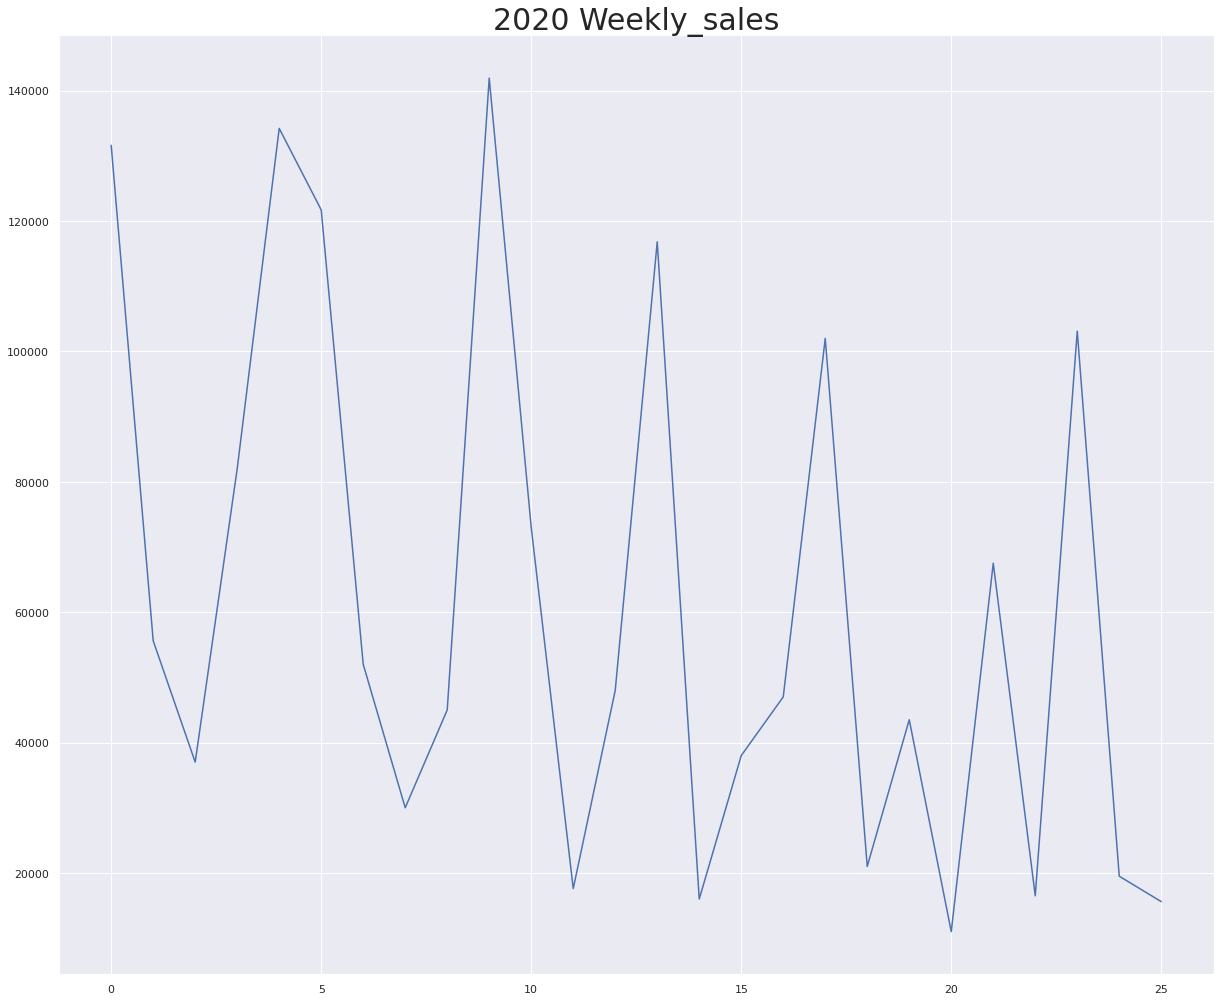

In [31]:
sale_2020 = sale_2020.groupby([ 'week_number'],  as_index=False)['sales'].sum()
sale_2020['sales'].plot()
plt.title( '2020 Weekly_sales', fontsize = 30)

In [32]:
# adding the weeks with zero sales in between
Zero_weeks ={'week_number':['12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38'],
             'sales' :[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]}

df = pd.DataFrame(Zero_weeks)
frames = [sale_2020, df]
sale_2020 = pd.concat(frames)

sale_2020['week_number'	]=sale_2020['week_number'	].astype(int)

sale_2020 = sale_2020.sort_values(by=['week_number'])
sale_2020.reset_index(drop= True, inplace = True)
sale_2020 = sale_2020[['week_number', 'sales']]
sale_2020['week_number'].astype(str)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
Name: week_number, dtype: object

# 2021

In [33]:
df4 =test_2021
#df4['message']= df['message'].str.replace('total=',"total ")
df4=df4[df4['message'].str.contains("sale|collection|total")]
df4['number']=df4['message3'].apply(lambda x: find_number(x))
df4['tokenized_words'] = df4['message3'].apply(nltk.word_tokenize)

df4['mode']= 0
#df4

for i in range(len(df4)):
    l1 =  df4.iloc[i,-2]
    for j in l1:
        if j in sale_words:
            df4.iloc[i,-1]= j

df5 = df4.copy()
num1 = split_number(df5)
df5['number_list'] = num1
zer_week = { 'week_number': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                             '15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32'],
            'sales': [17400,38300,81500, 139000, 100200, 161990, 126410, 59970, 85940,162400,141765,97573,51460,101900,
                      49460,30970,45980, 57940,23980,33480,0,0,0,0,0,28980,78920,62440,68440,58960,136290,109900]}

sale_2021 = pd.DataFrame(zer_week)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Text(0.5, 1.0, '2021 Weekly_sales')

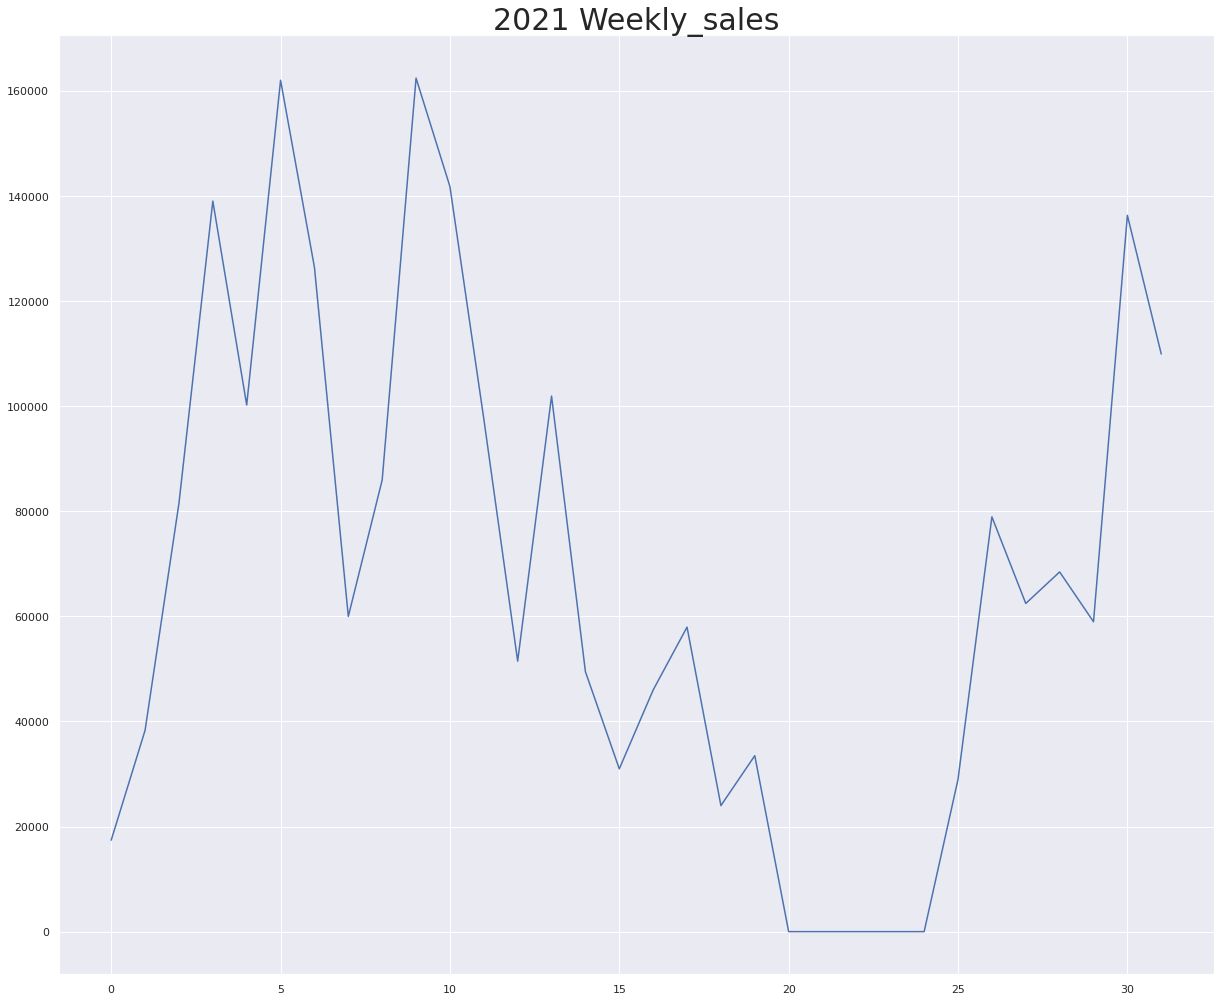

In [34]:
sale_2021['sales'].plot()
plt.title( '2021 Weekly_sales', fontsize = 30)

In [35]:
# creating the final sales dataframe for forecasting by merging 2019,2020 and 2021 data

In [36]:
frames = [sale_2019,sale_2020,sale_2021]

sale_2019['week'] = 2019*100+ sale_2019['week_number']
sale_2020['week'] = 2020*100+ sale_2019['week_number']
sale_2021['week'] = 2021*100+ sale_2019['week_number']
weekly_sale = pd.concat(frames)

week_sales = weekly_sale[['week', 'sales']]
week_sales = week_sales.reset_index(drop=True)


Text(0.5, 1.0, 'Weekly_sales')

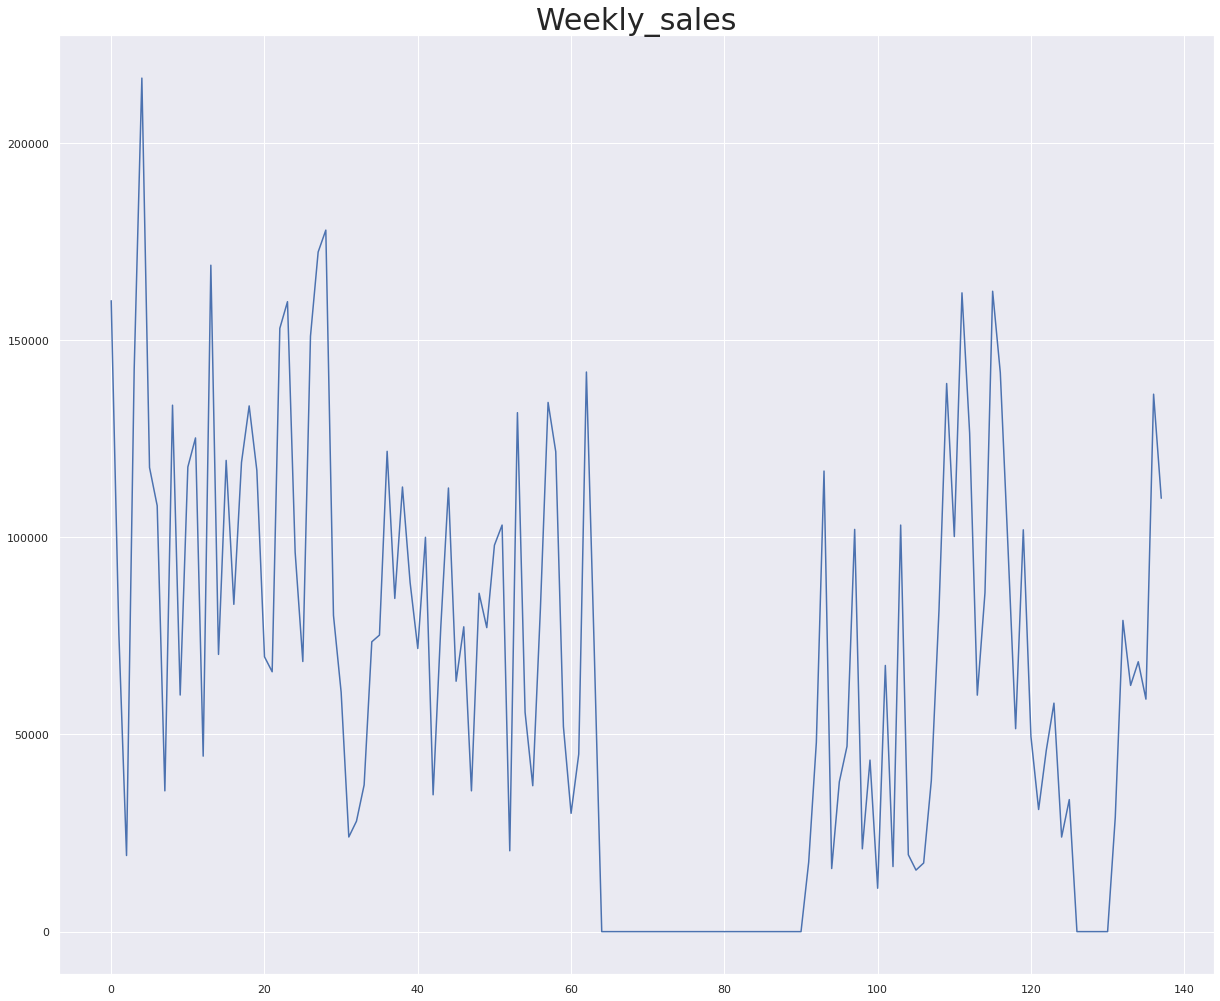

In [37]:
week_sales['sales'].plot()
plt.title( 'Weekly_sales', fontsize = 30)

In [38]:
# merging the sales datframe and covid factors
covid.rename(columns= {'Sum_of_footfall' : 'Sum_of_sales'}, inplace = True)
covid['Row Labels']=covid['Row Labels'].astype(int)
data2 =covid.merge(week_sales,how='left', left_on='Row Labels', right_on='week')
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Row Labels                     149 non-null    int64  
 1   Sum_of_dailY_vaccines          149 non-null    float64
 2   Sum_of_daily_hospitalizations  149 non-null    float64
 3   Sum_of_daily_deaths            149 non-null    float64
 4   Sum_of_daily_cases             149 non-null    float64
 5   Sum_of_mobility_mean           149 non-null    float64
 6   Sum_of_Lockdown                149 non-null    int64  
 7   sum_of_monthly_gdp             149 non-null    float64
 8   sum_of_daily_gdp*100           149 non-null    float64
 9   Sum_of_sales                   137 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 11.8 KB


In [39]:
#data2 = covid.copy()
data2.drop(columns = ['sales'], inplace = True)

In [40]:
data2

,Row Labels,Sum_of_dailY_vaccines,Sum_of_daily_hospitalizations,Sum_of_daily_deaths,Sum_of_daily_cases,Sum_of_mobility_mean,Sum_of_Lockdown,sum_of_monthly_gdp,sum_of_daily_gdp*100,Sum_of_sales,week
0,201901,0.00,0.0,0.00,0.0,0.4000,0,9.5,30.645161,105000.0,201901.0
1,201902,0.00,0.0,0.00,0.0,0.5600,0,13.3,42.903226,102998.0,201902.0
2,201903,0.00,0.0,0.00,0.0,0.5600,0,13.3,42.903226,19000.0,201903.0
3,201904,0.00,0.0,0.00,0.0,0.5600,0,13.3,42.903226,125000.0,201904.0
4,201905,0.00,0.0,0.00,0.0,0.5600,0,13.3,44.216590,111500.0,201905.0
...,...,...,...,...,...,...,...,...,...,...,...
144,202139,27112471.20,0.0,5019.43,203542.0,-116.5187,0,24.5,81.666667,NaN,NaN
145,202140,28825268.09,0.0,7404.00,151063.0,-106.3030,0,7.0,23.333333,NaN,NaN
146,202141,22521170.00,0.0,6950.00,130942.0,-81.6386,0,7.0,23.333333,NaN,NaN
147,202142,17017899.00,0.0,5446.00,107096.0,-65.9980,0,7.0,23.333333,NaN,NaN


# ML Models

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


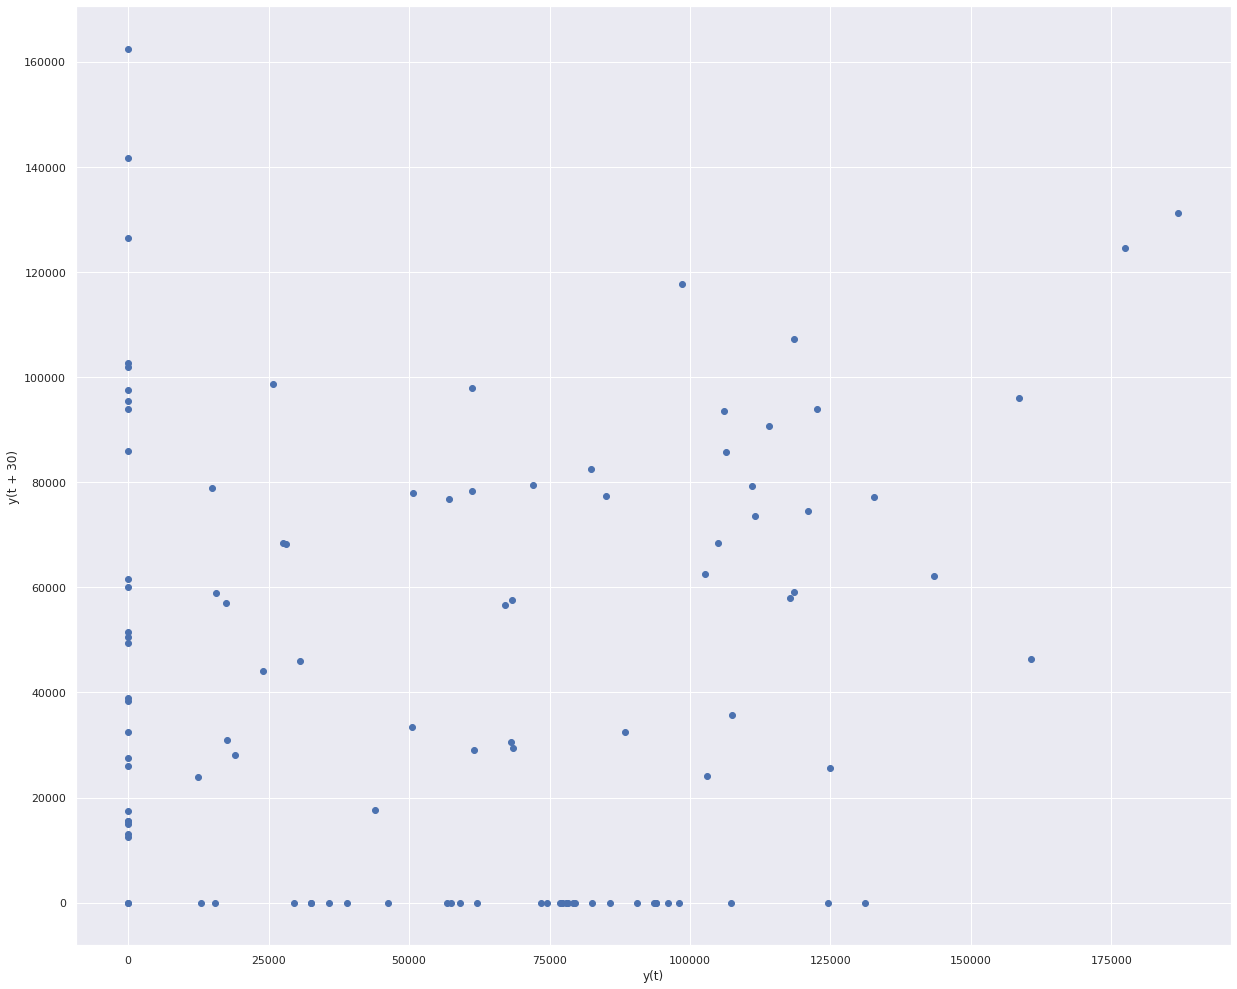

i vlue: 0                 i  Sum_of_sales
i             1.0           1.0
Sum_of_sales  1.0           1.0
i vlue: 7                      i  Sum_of_sales
i             1.000000      0.310125
Sum_of_sales  0.310125      1.000000
i vlue: 14                      i  Sum_of_sales
i             1.000000      0.269097
Sum_of_sales  0.269097      1.000000
i vlue: 21                      i  Sum_of_sales
i             1.000000      0.243251
Sum_of_sales  0.243251      1.000000
i vlue: 28                      i  Sum_of_sales
i             1.000000     -0.015143
Sum_of_sales -0.015143      1.000000


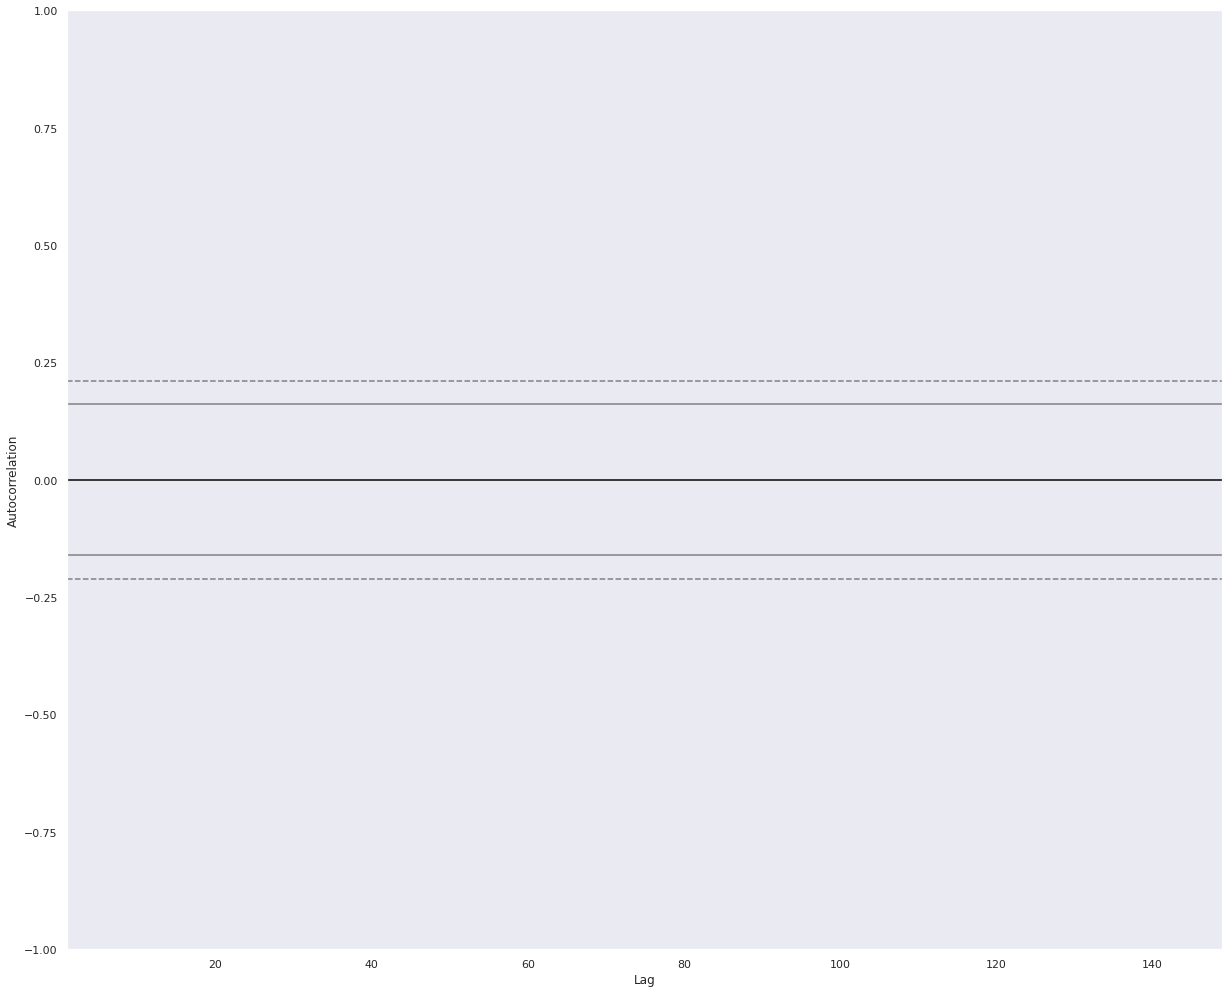

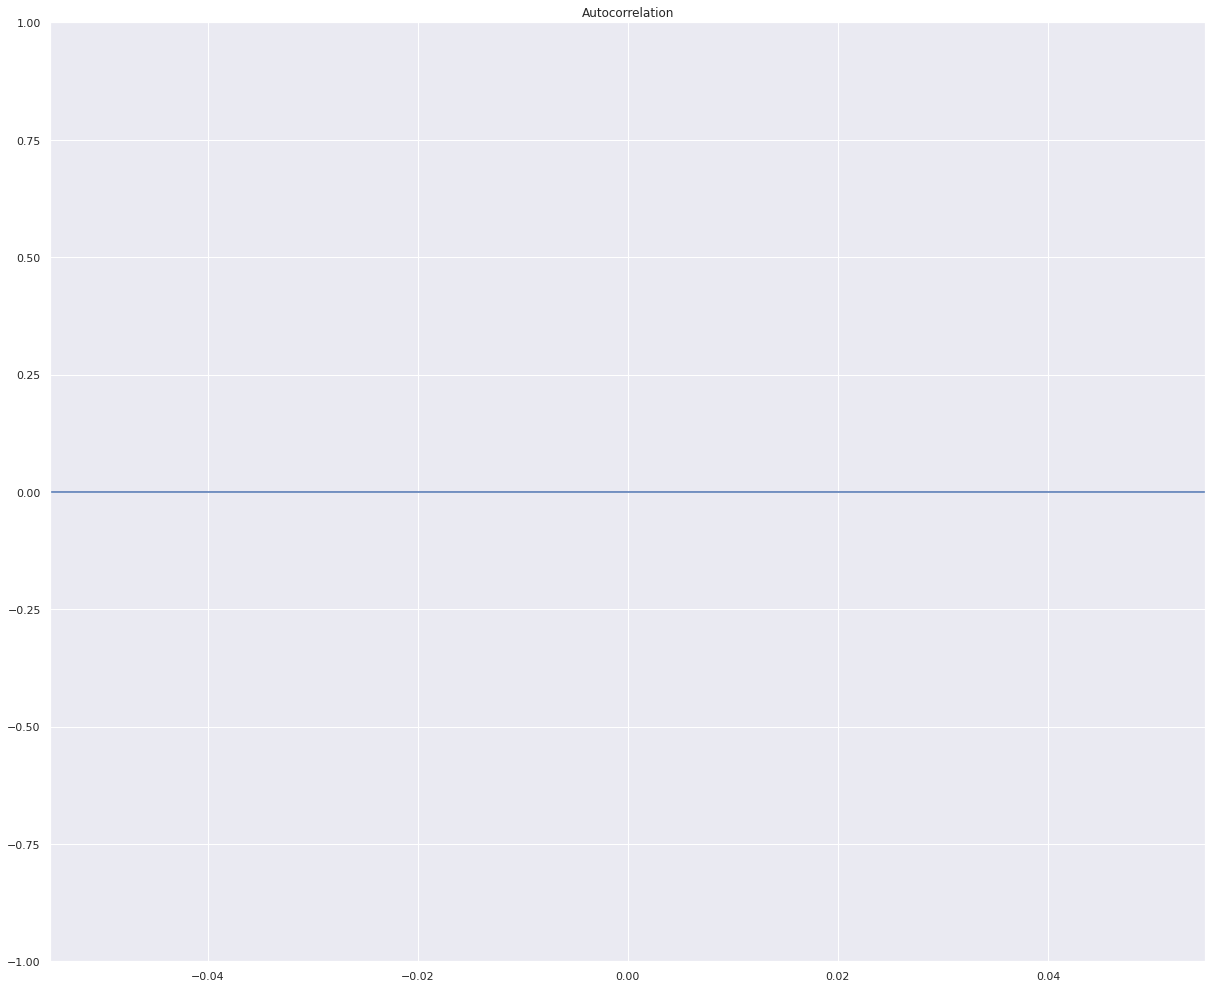

In [41]:
#data2 = full_data.copy()
# checking the auto correlation of daily sales with the past one day

lag_plot(data2['Sum_of_sales'], lag = 30)
plt.show()


# checking ad printing the correlation vlaues between various shifts

for i in range (0,31,7):
  shifted_values = data2['Sum_of_sales'].shift(i)
  dataframe = concat([data2['Sum_of_sales'].shift(i), data2['Sum_of_sales']], axis=1)
  dataframe.columns = ['i', 'Sum_of_sales']
  result = dataframe.corr()
  print("i vlue:",i,result)


# Autocorrelation Plots

autocorrelation_plot(data2['Sum_of_sales'])
plt.show()


from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data2['Sum_of_sales'], lags=31)
plt.show()

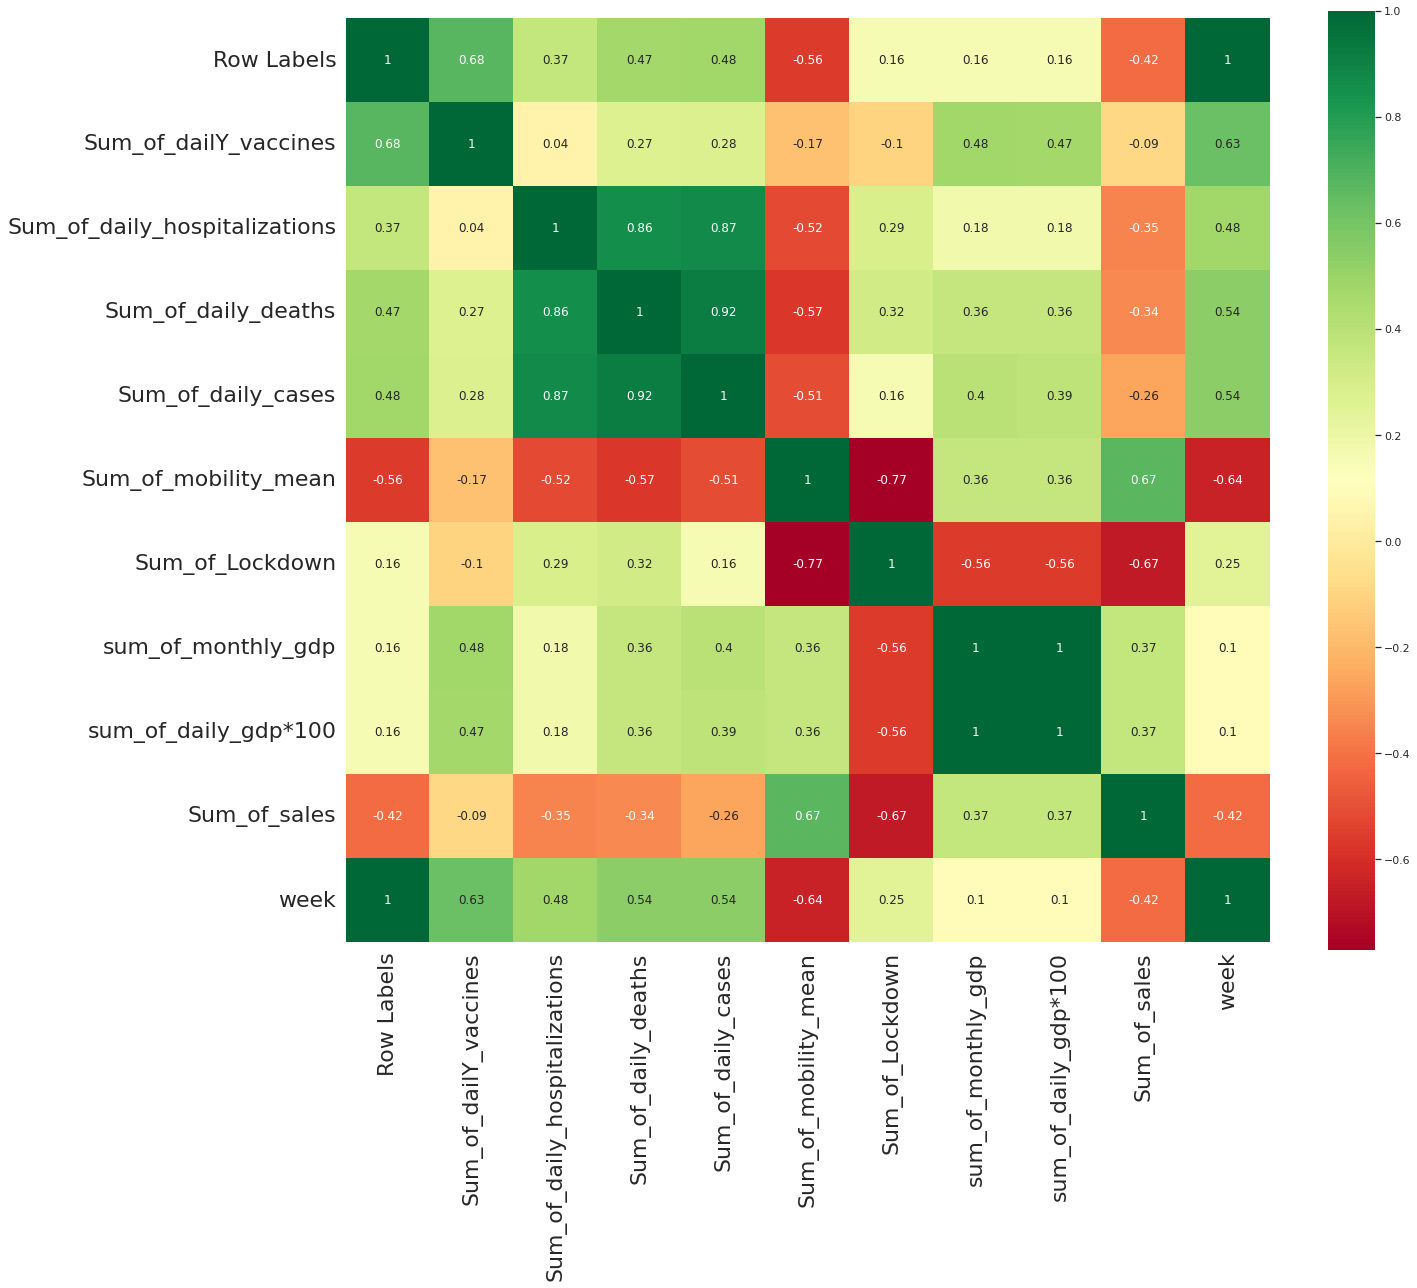

In [42]:
sns.set(rc={'figure.figsize':(20.7,17.2714)})
c = sns.heatmap(data2.corr().round(2), square=True, cmap='RdYlGn', annot=True)
c.tick_params(labelsize=22)

In [43]:
data2.columns

Index(['Row Labels', 'Sum_of_dailY_vaccines', 'Sum_of_daily_hospitalizations',
       'Sum_of_daily_deaths', 'Sum_of_daily_cases', 'Sum_of_mobility_mean',
       'Sum_of_Lockdown', 'sum_of_monthly_gdp', 'sum_of_daily_gdp*100',
       'Sum_of_sales', 'week'],
      dtype='object')

In [44]:
# craeting a subset of the  dataset
data2 = data2[[ 'Row Labels', 'Sum_of_dailY_vaccines', 'Sum_of_daily_hospitalizations',
       'Sum_of_daily_deaths', 'Sum_of_sales', 'Sum_of_daily_cases',
       'Sum_of_mobility_mean', 'Sum_of_Lockdown']]


In [45]:
# train test and val
Xtrain = data2.iloc[:137,]
Xtest = data2.iloc[137:,]
Xtest

Xval  = Xtrain.iloc[128:,]

Xval.tail()

Yval = Xval['Sum_of_sales']
#Yval1 = Xval['rsales']

Xtrain = Xtrain.iloc[:128,:]
Ytrain =Xtrain['Sum_of_sales']
#Ytrain1 =Xtrain['rsales']


# Xtrain.drop(columns = ['Sum_of_sales'], inplace =True)
# Xval.drop(columns = ['Sum_of_sales'], inplace =True)
# #Xval.drop(columns = ['rsales'], inplace =True)
# #Xtrain.drop(columns = ['rsales'], inplace =True)

In [46]:
Xtrain.drop(columns = ['Sum_of_sales'], inplace =True)
Xval.drop(columns = ['Sum_of_sales'], inplace =True)
#Xval.drop(columns = ['rsales'], inplace =True)
#Xtrain.drop(columns = ['rsales'], inplace =True)

In [47]:
# the parameters of the XGBoost odel were tuned earlier in another notebook 
# and the tuned parmeter are used in the final notebook

lasso = Lasso(alpha =0.0005)
model = xgboost.XGBRegressor(tree_method='gpu_hist',colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42
                 ) 

In [48]:
# scaling the data
scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain_t = scaler.transform(Xtrain)

scaler.fit(Xval)
Xval_t = scaler.transform(Xval)

In [49]:
# fitting and predicting the val values
model.fit(Xtrain, Ytrain)
y =model.predict(Xval)

# predicting the train values and creating the dataset with attributes(predictions, actual)
ytrain_pre =model.predict(Xtrain)
# yy = data2['Sum_of_sales'].rolling(4).mean()

# predictions = np.concatenate([ytrain_pre,y])
# predictions = pd.DataFrame(predictions, columns =['Predictions'])

# predictions["ractual"] =yy
# predictions['rpredictions'] = predictions['Predictions'].rolling(4).mean()
# val =predictions.iloc[128:,1:]
# RMSE_train= math.sqrt(metrics.mean_squared_error(val['ractual'], val['rpredictions']))
# r_square_train = metrics.r2_score(val['ractual'], val['rpredictions'])
# print("VAL STATSR:")
# print("R2 :",r_square_train)
# print("RMSE :",RMSE_train)


RMSE_train= math.sqrt(metrics.mean_squared_error(Yval, y))
r_square_train = metrics.r2_score(Yval, y)
print("VAL STATSR:")
print("R2 :",r_square_train)
print("RMSE :",RMSE_train)


[03:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
VAL STATSR:
R2 : 0.7963916242552264
RMSE : 13780.37652919698


In [50]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [51]:

# fitting and predicting the val values

model_lgb.fit(Xtrain, Ytrain)
yl =model_lgb.predict(Xval)


# # predicting the train values and creating the dataset with attributes(predictions, actual)
# ytrain_pre =model_lgb.predict(Xtrain)
# yy = data2['Sum_of_sales'].rolling(2).mean()
# # yy = yy.iloc[3:,]
# # yy

# predictions_lgb = np.concatenate([ytrain_pre,yl])
# predictions_lgb = pd.DataFrame(predictions_lgb, columns =['Predictions'])

# predictions_lgb["ractual"] =yy
# predictions_lgb['rpredictions'] = predictions_lgb['Predictions'].rolling(2).mean()
# val_lgb =predictions_lgb.iloc[125:,1:]
# RMSE_train= math.sqrt(metrics.mean_squared_error(val_lgb['ractual'], val_lgb['rpredictions']))
# r_square_train = metrics.r2_score(val_lgb['ractual'], val_lgb['rpredictions'])
# print("VAL STATSR:")
# print("R2 :",r_square_train)
# print("RMSE :",RMSE_train)


RMSE_train= math.sqrt(metrics.mean_squared_error(Yval, yl))
r_square_train = metrics.r2_score(Yval, yl)
print("VAL STATSR:")
print("R2 :",r_square_train)
print("RMSE :",RMSE_train)



VAL STATSR:
R2 : 0.7270469294571512
RMSE : 15955.383843485402


In [52]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
  #      self.models_ = []
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [53]:
averaged_models = AveragingModels(models = (model, model_lgb))
averaged_models.fit(Xtrain,Ytrain)
yavg =averaged_models.predict(Xval)

RMSE_train= math.sqrt(metrics.mean_squared_error(Yval, yavg))
r_square_train = metrics.r2_score(Yval, yavg)
print("VAL STATs")
print("R2 :",r_square_train)
print("RMSE :",RMSE_train)


# RMSE_train= math.sqrt(metrics.mean_squared_error(Ytrain, averaged_models.predict(Xtrain)))
# r_square_train = metrics.r2_score(Ytrain, averaged_models.predict(Xtrain))
# print("TRAIN STATs")
# print("R2 :",r_square_train)
# print("RMSE :",RMSE_train)

[03:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
VAL STATs
R2 : 0.8330499489474348
RMSE : 12478.332180113499


In [54]:
# training the model onn the entire train data and predicting the future sales
Xtrain = data2.iloc[:137,]
Ytrain = Xtrain['Sum_of_sales']
Xtrain.drop(columns = ['Sum_of_sales'], inplace =True)
Xtest.drop(columns = ['Sum_of_sales'], inplace = True)
averaged_models.fit(Xtrain,Ytrain)
y_test = averaged_models.predict(Xtest)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[03:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
# making dtafarame of predictions train and test
#y_test = pd.DataFrame(y_test )
y_train_pred = averaged_models.predict(Xtrain)
y_train_pred = np.where(y_train_pred < 0, 0, y_train_pred)

train_predictions = pd.DataFrame(y_train_pred )

predictions = np.concatenate([y_train_pred,y_test])
# train_predictions

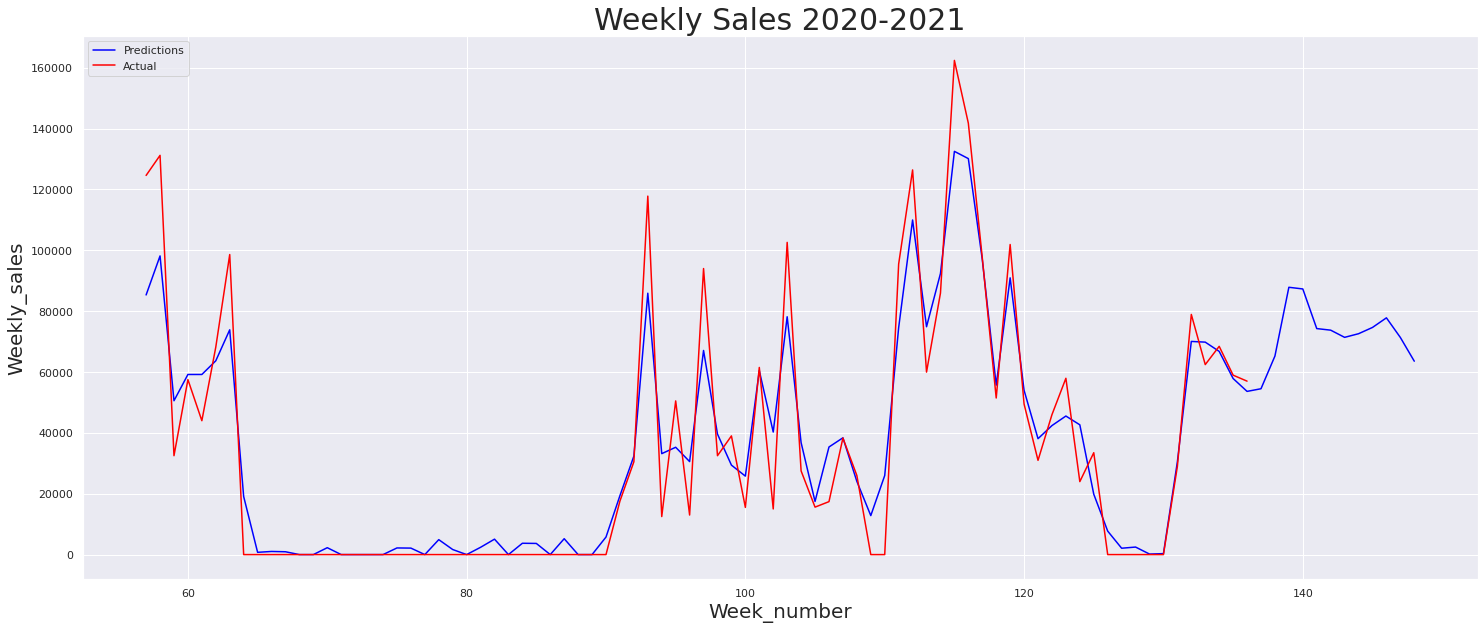

R2 : 0.8330499489474348
RMSE : 12478.332180113499


In [56]:
dataframe=pd.DataFrame(predictions, columns=['Predictions'])
dataframe['Actual'] = data2['Sum_of_sales']

dataframe = dataframe.iloc[57:]

plt.figure(figsize=(25,10))
plt.xlabel('Week_number', fontsize = 20)
plt.ylabel('Weekly_sales', fontsize = 20)

ax1 = dataframe.Predictions.plot(color='blue', grid=True, label='Predictions')
ax2 = dataframe.Actual.plot(color='red', grid=True, secondary_y=False, label='Actual')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.title( 'Weekly Sales 2020-2021', fontsize = 30)

plt.legend( l1+l2, loc=2)
plt.show()

print("R2 :",r_square_train)
print("RMSE :",RMSE_train)
 